# Opinion Mining et analyse des sentiments - Site TripAdvisor - Groupe8

* WebScraping

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import webbrowser
import io
import pandas as pd

def display(content, filename='output.html'):
    with open(filename, 'wb') as f:
         f.write(content)
         webbrowser.open(filename)


def get_soup(session, url, show=False):
    r = session.get(url)
    if show:
        display(r.content, 'temp.html')
    if r.status_code != 200: # not OK
        print('[get_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')


def post_soup(session, url, params, show=False):
    '''Read HTML from server and convert to Soup'''

    r = session.post(url, data=params)

    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[post_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')

def scrape(url, lang='ALL'):

    # create session to keep all cookies (etc.) between requests
    session = requests.Session()

    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
    })


    items = parse(session, url)

    return items

def parse(session, url):
    '''Get number of reviews and start getting subpages with reviews'''

    print('[parse] url:', url)

    soup = get_soup(session, url)

    if not soup:
        print('[parse] no soup:', url)
        return

    num_reviews = soup.find('span', class_='reviews_header_count').text # get text
    num_reviews = num_reviews[1:-1] 
    num_reviews = num_reviews.replace(',', '')
    num_reviews = int(num_reviews) # convert text into integer
    print('[parse] num_reviews ALL:', num_reviews)

    url_template = url.replace('.html', '-or{}.html')
    print('[parse] url_template:', url_template)

    items = []

    offset = 0

    while(True):
        subpage_url = url_template.format(offset)

        subpage_items = parse_reviews(session, subpage_url)
        if not subpage_items:
            break

        items += subpage_items

        if len(subpage_items) < 5:
            break

        offset += 5

    return items

def get_reviews_ids(soup):

    items = soup.find_all('div', attrs={'data-reviewid': True})

    if items:
        reviews_ids = [x.attrs['data-reviewid'] for x in items][::2]
        print('[get_reviews_ids] data-reviewid:', reviews_ids)
        return reviews_ids

def get_more(session, reviews_ids):

    url = 'https://www.tripadvisor.com/OverlayWidgetAjax?Mode=EXPANDED_HOTEL_REVIEWS_RESP&metaReferer=Hotel_Review'

    payload = {
        'reviews': ','.join(reviews_ids), # ie. "577882734,577547902,577300887",
        #'contextChoice': 'DETAIL_HR', # ???
        'widgetChoice': 'EXPANDED_HOTEL_REVIEW_HSX', # ???
        'haveJses': 'earlyRequireDefine,amdearly,global_error,long_lived_global,apg-Hotel_Review,apg-Hotel_Review-in,bootstrap,desktop-rooms-guests-dust-en_US,responsive-calendar-templates-dust-en_US,taevents',
        'haveCsses': 'apg-Hotel_Review-in',
        'Action': 'install',
    }

    soup = post_soup(session, url, payload)

    return soup

def parse_reviews(session, url):
    '''Get all reviews from one page'''

    print('[parse_reviews] url:', url)

    soup =  get_soup(session, url)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    hotel_name = soup.find('h1', class_='heading').text

    reviews_ids = get_reviews_ids(soup)
    if not reviews_ids:
        return

    soup = get_more(session, reviews_ids)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    items = []

    for idx, review in enumerate(soup.find_all('div', class_='reviewSelector')):

        badgets = review.find_all('span', class_='badgetext')
        if len(badgets) > 0:
            contributions = badgets[0].text
        else:
            contributions = '0'

        if len(badgets) > 1:
            helpful_vote = badgets[1].text
        else:
            helpful_vote = '0'
        user_loc = review.select_one('div.userLoc strong')
        if user_loc:
            user_loc = user_loc.text
        else:
            user_loc = ''
        
        #test=soup.find_all('div', class_='memberOverlayRedesign')
        #username_test=test.find('div', class_='username').text
        #other_test=test.find('ul', class_='memberdescriptionReviewEnhancements').text
        
        bubble_rating = review.select_one('span.ui_bubble_rating')['class']
        bubble_rating = bubble_rating[1].split('_')[-1]
        reviewer_name=str(review.find('div', class_='info_text').div)
        l=len(reviewer_name)
        reviewer_name=reviewer_name[5:l-6]
        if (review.find('div', class_={'userLoc':True})):
            reviewer_location=str(review.find('div', class_='userLoc').strong)
            ll=len(reviewer_location)
            reviewer_location=reviewer_location[8:ll-9]
        else: 
            reviewer_location="NA"

        item = {
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'], # 'ratingDate' instead of 'relativeDate'
            'reviewer_name': reviewer_name,
            'reviewer_location': reviewer_location,
            'bubble_rating': bubble_rating[0],
            'review_title': review.find('span', class_='noQuotes').text,
            
            #'test1': username_test,
            #'test2': other_test,
       }

        items.append(item)
        print('\n--- review ---\n')
        for key,val in item.items():
            print(' ', key, ':', val)

    print()

    return items

def write_in_csv(items, filename='results.csv',
                  headers=['hotel name', 'review title', 'review body',
                           'review date', 'contributions', 'helpful vote',
                           'user name' , 'user location', 'rating'],
              mode='w'):

    print('--- CSV ---')

    with io.open(filename, mode, encoding="utf-8") as csvfile:
        csv_file = csv.DictWriter(csvfile, headers)

        if mode == 'w':
            csv_file.writeheader()

        csv_file.writerows(items)

        
DB_COLUMN   = 'review_body'
DB_COLUMN1 = 'review_date'
DB_COLUMN2   ='review_title'
DB_COLUMN3   ='reviewer_name'
DB_COLUMN4   ='bubble_rating'
DB_COLUMN5   ='reviewer_location'
#DB_COLUMN6   ='test2'
start_urls = [
    'https://www.tripadvisor.com/Restaurant_Review-g187147-d1080856-Reviews-McDonalds_Champs_Elysees-Paris_Ile_de_France.html',
]

headers = [ 
    DB_COLUMN, 
    DB_COLUMN1,
    DB_COLUMN2,
    DB_COLUMN3,
    DB_COLUMN4,
    DB_COLUMN5,
    #DB_COLUMN6,
]

lang = 'it'


for url in start_urls:

    # get all reviews for 'url' and 'lang'
    items = scrape(url)

    if not items:
        print('No reviews')
    else:
        # write in CSV
        filename = url.split('Reviews-')[1][:-5]
        print('filename:', filename)
        write_in_csv(items, filename + '.csv', headers, mode='w')

* Importation du fichier :

In [1]:
import pandas as pd
df = pd.read_csv("McDonalds_Champs_Elysees-Paris_Ile_de_France.csv")

* Aperçu sur les données

In [2]:
df.head()

,review_body,review_date,review_title,reviewer_name,bubble_rating,reviewer_location
0,Have to admit I am not a great fan of McDonald...,"February 29, 2020",Just another maccy dees,JednSasha,3,"Stoke-on-Trent, United Kingdom"
1,Food was fine. Staff were undesirably rude!Fam...,"February 15, 2020",Rude... Absolute disgrace. AVOID!!!!,paulinemJ364RO,1,"Newcastle, Australia"
2,We went here to enjoy the Golden Arches fries....,"November 5, 2019",Fries were almost cold,Red A,1,"Waco, Texas"
3,When I visited this McDonalds I was excited to...,"November 2, 2019",Overpriced and disappointing,bonsamedi,2,"Paris, France"
4,This restaurent was a mad uprade from the one ...,"October 2, 2019",Bonjour de la merveille Britannique lisandra. ...,reviewgirl1977,4,"Shrivenham, United Kingdom"


In [60]:
df.shape

(540, 6)

## Data preprocessing

In [3]:
import datetime
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
import string
from gensim import corpora, models, similarities
import time
import operator

unable to import 'smart_open.gcs', disabling that module


In [4]:
# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.lower()
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    if ";" in text: text = text.replace(";\"","\";")    
    #text = text.replace(".",".<stop>")
    #text = text.replace(";",";<stop>")
    #text = text.replace("?","?<stop>")
    #text = text.replace("!","!<stop>")
    #text = text.replace("<prd>",".")
    #sentences = text.split("<stop>")
    #sentences = sentences[:-1]
    #sentences = [s.strip() for s in sentences]
    return text

In [5]:
content = df.review_body
content

0      Have to admit I am not a great fan of McDonald...
1      Food was fine. Staff were undesirably rude!Fam...
2      We went here to enjoy the Golden Arches fries....
3      When I visited this McDonalds I was excited to...
4      This restaurent was a mad uprade from the one ...
5      The wait for the women's toilet was 15mins. Wh...
6      Do you know how they call double bigmac in Fra...
7      For a busy location service was fast and frien...
8      Staff appear disorganized and unmotivated. Ove...
9      Had two cheese and egg mcmuffins, 2 coffees an...
10     Have to admit I am not a great fan of McDonald...
11     Food was fine. Staff were undesirably rude!Fam...
12     We went here to enjoy the Golden Arches fries....
13     When I visited this McDonalds I was excited to...
14     This restaurent was a mad uprade from the one ...
15     The wait for the women's toilet was 15mins. Wh...
16     Do you know how they call double bigmac in Fra...
17     For a busy location serv

In [6]:
phrases = []
for ph in content:
    phrases.append(split_into_sentences(ph))

In [7]:
phrases

[" have to admit i am not a great fan of mcdonalds but it is a great place for a quickish snack, i doubt it can really be classed as a 'fast food establishment' anymore.the one on the champs elysees occupies an ideal position from the company's point of view just a 100 mtrs from the arc de triomphe it is extremely busy, but a large restaurant with an upstairs seating area which means i was coping even at lunchtime.the food was no different to any other mcdonalds i have ever visited and well priced compared with any place to eat near a paris landmark/tourist attraction, we saw coffee on sale near the eifel tower at 16 euros per cup, were charge 22 euros for a cup of tea, small beer and small bottle of water more than half a mile from the tower so that in itself is a major point.ordering is almost totally be card/automatic ordering machine which i personally find a little difficult to understand but would be child's play to most regular uses and there does seem to be ample machines withi

In [8]:
data_clean = pd.DataFrame(phrases)
data_clean.columns = ['The review']
data_clean

,The review
0,have to admit i am not a great fan of mcdonal...
1,food was fine. staff were undesirably rude!fa...
2,we went here to enjoy the golden arches fries...
3,when i visited this mcdonalds i was excited t...
4,this restaurent was a mad uprade from the one...
5,the wait for the women's toilet was 15mins. w...
6,do you know how they call double bigmac in fr...
7,for a busy location service was fast and frie...
8,staff appear disorganized and unmotivated. ov...
9,"had two cheese and egg mcmuffins, 2 coffees a..."


In [9]:
filtering_data = []
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

In [10]:
for stop_words in phrases:
    filtered_sentence = [w for w in stop_words if not w in stopWords]
    filtering_data.append(filtered_sentence)

In [11]:
phrases

[" have to admit i am not a great fan of mcdonalds but it is a great place for a quickish snack, i doubt it can really be classed as a 'fast food establishment' anymore.the one on the champs elysees occupies an ideal position from the company's point of view just a 100 mtrs from the arc de triomphe it is extremely busy, but a large restaurant with an upstairs seating area which means i was coping even at lunchtime.the food was no different to any other mcdonalds i have ever visited and well priced compared with any place to eat near a paris landmark/tourist attraction, we saw coffee on sale near the eifel tower at 16 euros per cup, were charge 22 euros for a cup of tea, small beer and small bottle of water more than half a mile from the tower so that in itself is a major point.ordering is almost totally be card/automatic ordering machine which i personally find a little difficult to understand but would be child's play to most regular uses and there does seem to be ample machines withi

## 1/ Définir les objectifs

* Objectif 1: Avoir une idée générale sur la E-réputation de MacDonald's France (Positive ou négative)
* Objectif 2: Avoir une idée sur les facteurs qui contribuent à cette E-réputation

In [12]:
data_clean1=data_clean[["The review"]]
data_clean1["bubble_rating"]=df["bubble_rating"]

In [13]:
data_clean1

,The review,bubble_rating
0,have to admit i am not a great fan of mcdonal...,3
1,food was fine. staff were undesirably rude!fa...,1
2,we went here to enjoy the golden arches fries...,1
3,when i visited this mcdonalds i was excited t...,2
4,this restaurent was a mad uprade from the one...,4
5,the wait for the women's toilet was 15mins. w...,3
6,do you know how they call double bigmac in fr...,5
7,for a busy location service was fast and frie...,5
8,staff appear disorganized and unmotivated. ov...,1
9,"had two cheese and egg mcmuffins, 2 coffees a...",5


# Les méthodes d'analyse

### Première méthode:"bubble_rating"

* Notre analyse va se porter sur la colonne "bubble_rating" et qui représente la note donnée par le client sur MacDo
* Il s'agit d'une méthode descriptive. 

### 1/ Commençons par voir la moyenne et la médiane de la totalité des retours.

In [14]:
data_clean1.describe()

,bubble_rating
count,540.000000
mean,2.900000
std,1.373348
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


### Interprétation:

* Interprétation: On remarque que la médiane et la moyenne sont presque égale à 3 (3 et 2.9). Et ceci nous montre que les clients sont plus au moins satisfaits par les services fournis par MacDo France.

### 2/Passons maintenant à une analyse plus détataillée de cette variable ("bubble_rating") :

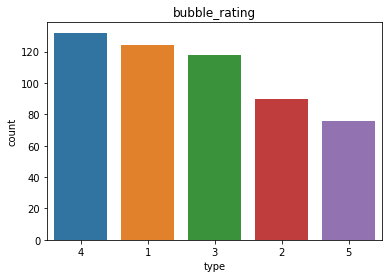

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.countplot(
  x='bubble_rating',
  data=data_clean1,
  order=data_clean1.bubble_rating.value_counts().index
)

plt.xlabel("type")
plt.title("bubble_rating");

In [17]:
print("Rating"" ""Totale")
print(data_clean1.bubble_rating.value_counts())

Rating Totale
4    132
1    124
3    118
2     90
5     76
Name: bubble_rating, dtype: int64


### Interprétation:

On remarque que 132 des clients ont donné une note=4 et 124 clients ont noté MacDo France avec une note=1 puis on trouve que 118 clients ont donné une note=3. Et cette répartition nous permet de déduire 2 intérprétations:
* Ce résultat confirme le résultat précédent de la moyenne et la médiane et qui sont = 3.
* On peut dire que la majorité des clients sont satisfaits par les services de MacDo france puisque le nombre totale des clients qui ont donné une note >=3 est égal à 326 tandis que le nombre des clients qui ont donné une note inférieure à 3 est égal à 214. Mais on ne peut pas dire que la réputation de MacDo est très positive puisque on peut constater une certaine opposition et meme contradiction puisque les deux plus grandes portions des avis sont 4 étoiles (132 avis) et 1 étoile (124 avis). Donc on peut dire que l'image est soit très positive pour une portions des clients et soit très négative pour d'autres clients.

### 3/ On va continuer maintenant avec le meme principe donc on va supposer que les clients qui ont donné une note >=3 ont aussi écrit un retour positif et les autres ont donné un retour négatif

In [18]:
data_clean1["review_type"] = data_clean1["bubble_rating"].apply(
  lambda x: "bad" if x < 3 else "good"
)

In [19]:
data_clean1.review_type.value_counts()

good    326
bad     214
Name: review_type, dtype: int64

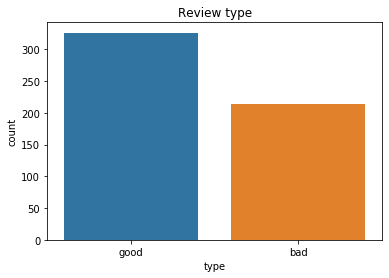

In [20]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=data_clean1,
  order=data_clean1.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type");

### Interprétation:

* Comme on la déjà mentionnée dans l'interprétation précedente on peut dire que d'une manière générale la E-réputation de MacDo est positive puisque le nombre de bon retour dépasse le nombre de mauvais retours.
* Mais ceci ne doit pas cacher l'opposition et la contraduction qu'on en a déjà parlé dans les interprétations précédentes.

### 2 ème méthode: Word Cloud

* Afin de déterminer les facteurs qui ont abouti à la constuction de cette E-réputation de MacDo France, on va réaliser deux WordCloud (une pour les reviews positives et une pour les négatives) qui vont nous permettre de dégager les mots les plus fréquentes dans chacun des cas et donc déduire les facteurs agissants sur l'image de MacDo. 

In [21]:
good_reviews = data_clean1[data_clean1.review_type == "good"]
bad_reviews = data_clean1[data_clean1.review_type == "bad"]

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
good_reviews_text = " ".join(good_reviews["The review"].to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews["The review"].to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bad_reviews_text)

In [25]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

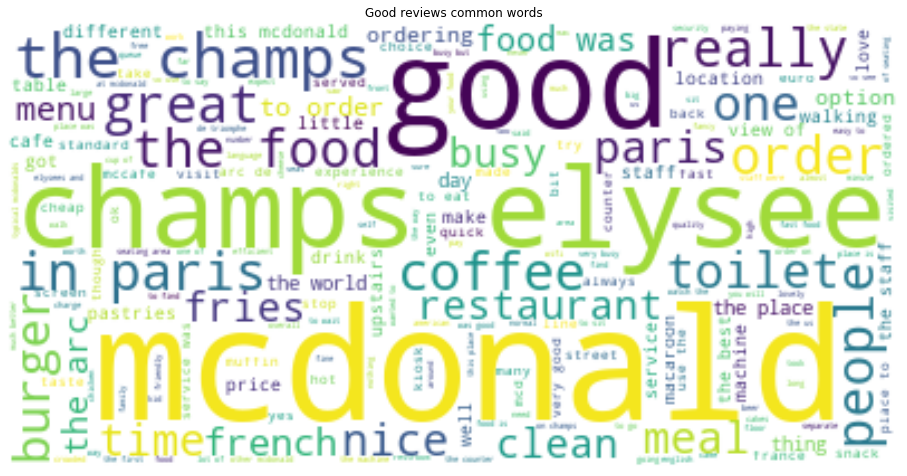

In [26]:
show_word_cloud(good_reviews_cloud, "Good reviews common words")

### Interprétation

D'après ce word cloud, on remarque que les mots les plus fréquents dans les retours positifs peuvent etre classés dans 3 groupes:
* "Place, champs elysee, paris, location...": la localisation et le cadre des restaurants 
* "Burger, meal,fries, macaron, large..": les produits de MacDo
* "clean,experience,people,staff,fast, quick, service , cheap, price": les services, le comportement du staff , l'hygiène, le temps d'attente réduit, le bas prix.

=> et ceci nous permet de dire que ces derniers  sont les facteurs qui ont contribué le plus à cette image positive de MacDo.

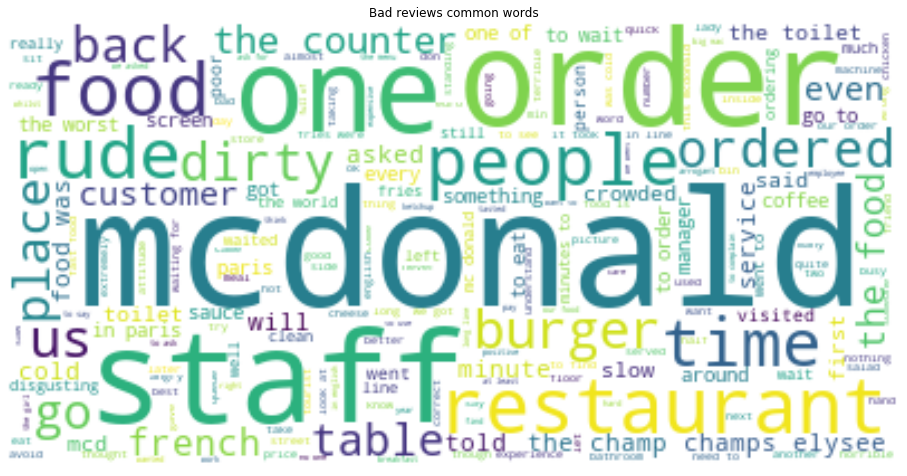

In [27]:
show_word_cloud(bad_reviews_cloud, "Bad reviews common words")

### Interprétation:

D'après ce word cloud, on remarque que les mots les plus fréquents dans les retours négatifs peuvent etre classés dans 3 groupes:
* "cold,ordered,time,wait..": le temps d'attente lors des commandes
* "toilet,dirty,bathroom...": l'hygiène dans MacDo
* "rude, staff, french, english" les services (certains employés ont manifesté des signes d'impolitesse, certains d'employés ne peuvent pas communiquer en anglais)

=> Afin d'éviter les mauvais retours, MacDo France doit agir sur ces aspects et ceci lui permettra l'amélioration de sa réputation.

## 3 ème méthode: Evaluation de l'image de MacDo France en focalusiant sur les textes "des reviews"

* Nous allons maintenant analyser les textes écrits par les clients de MacDo France et non pas sur la note attribuée et comparer les résultats qu'on va les obtenir avec les résultats précédents.
* On va utiliser TEXTBLOB afin d'obtenir une note de polarité

In [28]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean['polarity'] = data_clean['The review'].apply(pol)
data_clean['subjectivity'] = data_clean['The review'].apply(sub)
data_clean["Reviewer Name"]=df["reviewer_name"]
data_clean

,The review,polarity,subjectivity,Reviewer Name
0,have to admit i am not a great fan of mcdonal...,0.148884,0.518661,JednSasha
1,food was fine. staff were undesirably rude!fa...,-0.195833,0.612500,paulinemJ364RO
2,we went here to enjoy the golden arches fries...,0.408333,0.680556,Red A
3,when i visited this mcdonalds i was excited t...,0.076944,0.525972,bonsamedi
4,this restaurent was a mad uprade from the one...,0.093750,0.525000,reviewgirl1977
5,the wait for the women's toilet was 15mins. w...,0.032333,0.432667,17sherryp
6,do you know how they call double bigmac in fr...,0.500000,0.150000,Orwell1996
7,for a busy location service was fast and frie...,0.293750,0.525000,Erwin V
8,staff appear disorganized and unmotivated. ov...,0.185076,0.480682,Chrisochiai
9,"had two cheese and egg mcmuffins, 2 coffees a...",0.199333,0.712000,Fatima A


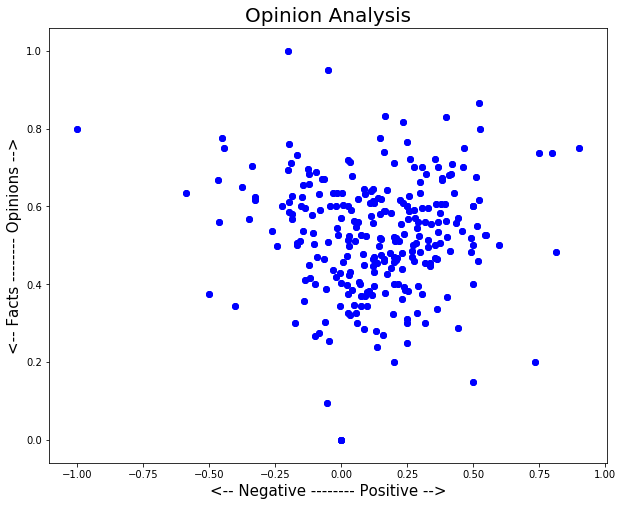

In [29]:
# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data_clean.index):
    x = data_clean.polarity.loc[index]
    y = data_clean.subjectivity.loc[index]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data_clean['Reviewer Name'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Opinion Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

### Interprétation:

En analysant les points qu'on a obtenu et ceci par rapport à l'axe des abscisse:
* la majorité des points sont entre 0 et 1 avec 0 représente un avis plus au moins neutre et en allant vers 1 les retours deviennent de plus en plus positifs. Alors un point d'abscisse 1 est un point représentant un avis très positive. Et inversement en allant vers -1.
* Plus précisement la majorité des points sont entre 0 et 0.5.

=> Donc d'une manière générale on peut dire que les retours sur MacDo France sont positifs. Mais puisqu'ils sont entre 0 et 0.5 ces clients donne un retour positif mais il n'est pas totoalement satisfait. Alors dans ces retours en trouvera bien évidémment des mots d'insatisfaction par rapport à quelques services que les décideurs de MacDo France doivent les prendre en considération afin de plus améliorer la réputation de MacDo.

=> Ce résultat confirme les interprétations qu'on a déjà dégagé par les autres méthodes.

How people are reacting on Mc'donalds by analyzing 540 avis.

General Report: 
Weakly Positive

Detailed Report: 
22.59% people thought it was positive
47.78% people thought it was weakly positive
1.85% people thought it was strongly positive
4.44% people thought it was negative
21.48% people thought it was weakly negative
0.00% people thought it was strongly negative
1.48% people thought it was neutral


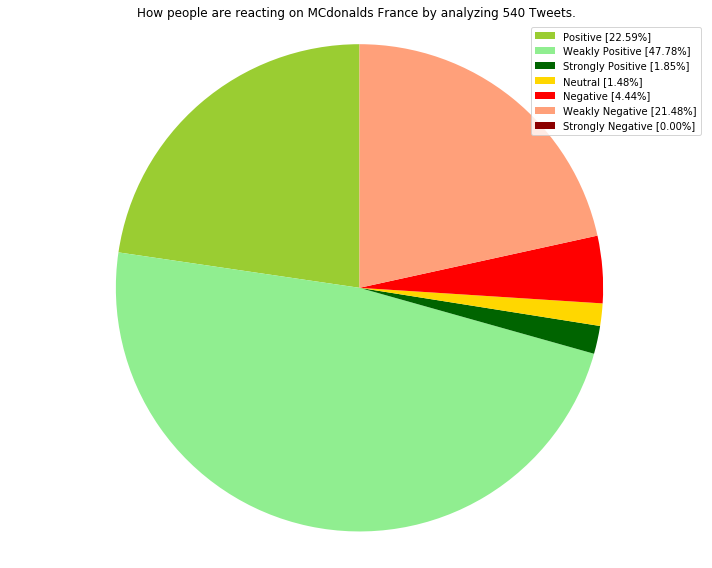

In [57]:
data_clean_test=data_clean
class OpinionAnalysis:

    

    def DownloadData(self):
        
        #csvFile = open('data_processed.csv', 'a')

        # Use csv writer
        #csvWriter = csv.writer(csvFile)


        # creating some variables to store info
        polarity = 0
        positive = 0
        wpositive = 0
        spositive = 0
        negative = 0
        wnegative = 0
        snegative = 0
        neutral = 0
        i=0
        tp=0
        #pos = pd.DataFrame(columns=['text',	'created_at',	'source',	'tokens',	'neg',	'neu',	'pos',	'compound'])
        
        

        # iterating through tweets fetched
        for tweet in data_clean_test['The review']:
            

            #Append to temp so that we can store in csv later. I use encode UTF-8
            #self.tweetText.append(self.cleanTweet(tweet.text).encode('utf-8'))
            # print (tweet.text.translate(non_bmp_map))    #print tweet's text
            analysis = TextBlob(tweet)
            # print(analysis.sentiment)  # print tweet's polarity
            polarity += analysis.sentiment.polarity  # adding up polarities to find the average later

            if (analysis.sentiment.polarity == 0):  # adding reaction of how people are reacting to find average later
                neutral += 1
            elif (analysis.sentiment.polarity > 0 and analysis.sentiment.polarity <= 0.3):
                wpositive += 1
            elif (analysis.sentiment.polarity > 0.3 and analysis.sentiment.polarity <= 0.6):
                positive += 1
                #pos=pos.append(df.iloc[i])
                #i= i+1
                
            elif (analysis.sentiment.polarity > 0.6 and analysis.sentiment.polarity <= 1):
                spositive += 1
            elif (analysis.sentiment.polarity > -0.3 and analysis.sentiment.polarity <= 0):
                wnegative += 1
            elif (analysis.sentiment.polarity > -0.6 and analysis.sentiment.polarity <= -0.3):
                negative += 1
            elif (analysis.sentiment.polarity > -1 and analysis.sentiment.polarity <= -0.6):
                snegative += 1


        # Write to csv and close csv file
        #csvWriter.writerow(self.tweetText)
        #csvFile.close()
        NoOfTerms=len(df)
        # finding average of how people are reacting
        positive = self.percentage(positive, NoOfTerms)
        wpositive = self.percentage(wpositive, NoOfTerms)
        spositive = self.percentage(spositive, NoOfTerms)
        negative = self.percentage(negative, NoOfTerms)
        wnegative = self.percentage(wnegative, NoOfTerms)
        snegative = self.percentage(snegative, NoOfTerms)
        neutral = self.percentage(neutral, NoOfTerms)

        # finding average reaction
        polarity = polarity / NoOfTerms

        # printing out data
        print("How people are reacting on Mc'donalds by analyzing " + str(len(df)) + " avis.")
        print()
        print("General Report: ")
        

        if (polarity == 0):
            print("Neutral")
        elif (polarity > 0 and polarity <= 0.3):
            print("Weakly Positive")
        elif (polarity > 0.3 and polarity <= 0.6):
            print("Positive")
            p+=1
        elif (polarity > 0.6 and polarity <= 1):
            print("Strongly Positive")
        elif (polarity > -0.3 and polarity <= 0):
            print("Weakly Negative")
        elif (polarity > -0.6 and polarity <= -0.3):
            print("Negative")
            n+=1
        elif (polarity > -1 and polarity <= -0.6):
            print("Strongly Negative")

        print()
        print("Detailed Report: ")
        print(str(positive) + "% people thought it was positive")
        print(str(wpositive) + "% people thought it was weakly positive")
        print(str(spositive) + "% people thought it was strongly positive")
        print(str(negative) + "% people thought it was negative")
        print(str(wnegative) + "% people thought it was weakly negative")
        print(str(snegative) + "% people thought it was strongly negative")
        print(str(neutral) + "% people thought it was neutral")

        

        self.plotPieChart(positive, wpositive, spositive, negative, wnegative, snegative, neutral,'MCdonalds France', NoOfTerms)
        

    def cleanTweet(self, tweet):
        # Remove Links, Special Characters etc from tweet
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())

    # function to calculate percentage
    def percentage(self, part, whole):
        temp = 100 * float(part) / float(whole)
        return format(temp, '.2f')

    def plotPieChart(self, positive, wpositive, spositive, negative, wnegative, snegative, neutral, searchTerm, noOfSearchTerms):
        labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]','Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
                  'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]', 'Strongly Negative [' + str(snegative) + '%]']
        sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
        colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
        patches, texts = plt.pie(sizes, colors=colors, startangle=90)
        plt.legend(patches, labels, loc="best")
        plt.title('How people are reacting on ' + searchTerm + ' by analyzing ' + str(noOfSearchTerms) + ' Tweets.')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
objet = OpinionAnalysis()
objet.DownloadData()

# Objectif 3

* La position de MacDonald's France par rapport à ses concurrents

### Web scraping: Burger King

In [74]:
import requests
from bs4 import BeautifulSoup
import csv
import webbrowser
import io
import pandas as pd

def display(content, filename='output.html'):
    with open(filename, 'wb') as f:
         f.write(content)
         webbrowser.open(filename)


def get_soup(session, url, show=False):
    r = session.get(url)
    if show:
        display(r.content, 'temp.html')
    if r.status_code != 200: # not OK
        print('[get_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')


def post_soup(session, url, params, show=False):
    '''Read HTML from server and convert to Soup'''

    r = session.post(url, data=params)

    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[post_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')

def scrape(url, lang='ALL'):

    # create session to keep all cookies (etc.) between requests
    session = requests.Session()

    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
    })


    items = parse(session, url)

    return items

def parse(session, url):
    '''Get number of reviews and start getting subpages with reviews'''

    print('[parse] url:', url)

    soup = get_soup(session, url)

    if not soup:
        print('[parse] no soup:', url)
        return

    num_reviews = soup.find('span', class_='reviews_header_count').text # get text
    num_reviews = num_reviews[1:-1] 
    num_reviews = num_reviews.replace(',', '')
    num_reviews = int(num_reviews) # convert text into integer
    print('[parse] num_reviews ALL:', num_reviews)

    url_template = url.replace('.html', '-or{}.html')
    print('[parse] url_template:', url_template)

    items = []

    offset = 0

    while(True):
        subpage_url = url_template.format(offset)

        subpage_items = parse_reviews(session, subpage_url)
        if not subpage_items:
            break

        items += subpage_items

        if len(subpage_items) < 5:
            break

        offset += 5

    return items

def get_reviews_ids(soup):

    items = soup.find_all('div', attrs={'data-reviewid': True})

    if items:
        reviews_ids = [x.attrs['data-reviewid'] for x in items][::2]
        print('[get_reviews_ids] data-reviewid:', reviews_ids)
        return reviews_ids

def get_more(session, reviews_ids):

    url = 'https://www.tripadvisor.com/OverlayWidgetAjax?Mode=EXPANDED_HOTEL_REVIEWS_RESP&metaReferer=Hotel_Review'

    payload = {
        'reviews': ','.join(reviews_ids), # ie. "577882734,577547902,577300887",
        #'contextChoice': 'DETAIL_HR', # ???
        'widgetChoice': 'EXPANDED_HOTEL_REVIEW_HSX', # ???
        'haveJses': 'earlyRequireDefine,amdearly,global_error,long_lived_global,apg-Hotel_Review,apg-Hotel_Review-in,bootstrap,desktop-rooms-guests-dust-en_US,responsive-calendar-templates-dust-en_US,taevents',
        'haveCsses': 'apg-Hotel_Review-in',
        'Action': 'install',
    }

    soup = post_soup(session, url, payload)

    return soup

def parse_reviews(session, url):
    '''Get all reviews from one page'''

    print('[parse_reviews] url:', url)

    soup =  get_soup(session, url)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    hotel_name = soup.find('h1', class_='heading').text

    reviews_ids = get_reviews_ids(soup)
    if not reviews_ids:
        return

    soup = get_more(session, reviews_ids)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    items = []

    for idx, review in enumerate(soup.find_all('div', class_='reviewSelector')):

        badgets = review.find_all('span', class_='badgetext')
        if len(badgets) > 0:
            contributions = badgets[0].text
        else:
            contributions = '0'

        if len(badgets) > 1:
            helpful_vote = badgets[1].text
        else:
            helpful_vote = '0'
        user_loc = review.select_one('div.userLoc strong')
        if user_loc:
            user_loc = user_loc.text
        else:
            user_loc = ''
        
        #test=soup.find_all('div', class_='memberOverlayRedesign')
        #username_test=test.find('div', class_='username').text
        #other_test=test.find('ul', class_='memberdescriptionReviewEnhancements').text
        
        bubble_rating = review.select_one('span.ui_bubble_rating')['class']
        bubble_rating = bubble_rating[1].split('_')[-1]
        reviewer_name=str(review.find('div', class_='info_text').div)
        l=len(reviewer_name)
        reviewer_name=reviewer_name[5:l-6]
        if (review.find('div', class_={'userLoc':True})):
            reviewer_location=str(review.find('div', class_='userLoc').strong)
            ll=len(reviewer_location)
            reviewer_location=reviewer_location[8:ll-9]
        else: 
            reviewer_location="NA"

        item = {
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'], # 'ratingDate' instead of 'relativeDate'
            'reviewer_name': reviewer_name,
            'reviewer_location': reviewer_location,
            'bubble_rating': bubble_rating[0],
            'review_title': review.find('span', class_='noQuotes').text,
            
            #'test1': username_test,
            #'test2': other_test,
       }

        items.append(item)
        print('\n--- review ---\n')
        for key,val in item.items():
            print(' ', key, ':', val)

    print()

    return items

def write_in_csv(items, filename='results.csv',
                  headers=['hotel name', 'review title', 'review body',
                           'review date', 'contributions', 'helpful vote',
                           'user name' , 'user location', 'rating'],
              mode='w'):

    print('--- CSV ---')

    with io.open(filename, mode, encoding="utf-8") as csvfile:
        csv_file = csv.DictWriter(csvfile, headers)

        if mode == 'w':
            csv_file.writeheader()

        csv_file.writerows(items)

        
DB_COLUMN   = 'review_body'
DB_COLUMN1 = 'review_date'
DB_COLUMN2   ='review_title'
DB_COLUMN3   ='reviewer_name'
DB_COLUMN4   ='bubble_rating'
DB_COLUMN5   ='reviewer_location'
#DB_COLUMN6   ='test2'
start_urls = [
    'https://www.tripadvisor.com/Restaurant_Review-g187147-d5800727-Reviews-Burger_King-Paris_Ile_de_France.html',
]

headers = [ 
    DB_COLUMN, 
    DB_COLUMN1,
    DB_COLUMN2,
    DB_COLUMN3,
    DB_COLUMN4,
    DB_COLUMN5,
    #DB_COLUMN6,
]

lang = 'it'


for url in start_urls:

    # get all reviews for 'url' and 'lang'
    items = scrape(url)

    if not items:
        print('No reviews')
    else:
        # write in CSV
        filename = url.split('Reviews-')[1][:-5]
        print('filename:', filename)
        write_in_csv(items, filename + '.csv', headers, mode='w')

[parse] url: https://www.tripadvisor.com/Restaurant_Review-g187147-d5800727-Reviews-Burger_King-Paris_Ile_de_France.html
[parse] num_reviews ALL: 291
[parse] url_template: https://www.tripadvisor.com/Restaurant_Review-g187147-d5800727-Reviews-Burger_King-Paris_Ile_de_France-or{}.html
[parse_reviews] url: https://www.tripadvisor.com/Restaurant_Review-g187147-d5800727-Reviews-Burger_King-Paris_Ile_de_France-or0.html
[get_reviews_ids] data-reviewid: ['631518778', '618463284', '613437533', '613096040', '583689098', '574307349', '565624228', '563375037', '511352682', '445122122']

--- review ---

  review_body : I am traveling everyday since almost 3 weeks through Gare St-Lazare hoping to get a coffee or breakfast here but it never open as it’s written on the door ... 7:30am no 7:45 as its earliest ... today 07:48am still not open. No breakfast for me ... here ;)
  review_date : November 6, 2018
  reviewer_name : tonin92
  reviewer_location : Villiers-sur-Marne, France
  bubble_rating : 1
 

### Web scraping King Marcel

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import webbrowser
import io
import pandas as pd

def display(content, filename='output.html'):
    with open(filename, 'wb') as f:
         f.write(content)
         webbrowser.open(filename)


def get_soup(session, url, show=False):
    r = session.get(url)
    if show:
        display(r.content, 'temp.html')
    if r.status_code != 200: # not OK
        print('[get_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')


def post_soup(session, url, params, show=False):
    '''Read HTML from server and convert to Soup'''

    r = session.post(url, data=params)

    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[post_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')

def scrape(url, lang='ALL'):

    # create session to keep all cookies (etc.) between requests
    session = requests.Session()

    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
    })


    items = parse(session, url)

    return items

def parse(session, url):
    '''Get number of reviews and start getting subpages with reviews'''

    print('[parse] url:', url)

    soup = get_soup(session, url)

    if not soup:
        print('[parse] no soup:', url)
        return

    num_reviews = soup.find('span', class_='reviews_header_count').text # get text
    num_reviews = num_reviews[1:-1] 
    num_reviews = num_reviews.replace(',', '')
    num_reviews = int(num_reviews) # convert text into integer
    print('[parse] num_reviews ALL:', num_reviews)

    url_template = url.replace('.html', '-or{}.html')
    print('[parse] url_template:', url_template)

    items = []

    offset = 0

    while(True):
        subpage_url = url_template.format(offset)

        subpage_items = parse_reviews(session, subpage_url)
        if not subpage_items:
            break

        items += subpage_items

        if len(subpage_items) < 5:
            break

        offset += 5

    return items

def get_reviews_ids(soup):

    items = soup.find_all('div', attrs={'data-reviewid': True})

    if items:
        reviews_ids = [x.attrs['data-reviewid'] for x in items][::2]
        print('[get_reviews_ids] data-reviewid:', reviews_ids)
        return reviews_ids

def get_more(session, reviews_ids):

    url = 'https://www.tripadvisor.com/OverlayWidgetAjax?Mode=EXPANDED_HOTEL_REVIEWS_RESP&metaReferer=Hotel_Review'

    payload = {
        'reviews': ','.join(reviews_ids), # ie. "577882734,577547902,577300887",
        #'contextChoice': 'DETAIL_HR', # ???
        'widgetChoice': 'EXPANDED_HOTEL_REVIEW_HSX', # ???
        'haveJses': 'earlyRequireDefine,amdearly,global_error,long_lived_global,apg-Hotel_Review,apg-Hotel_Review-in,bootstrap,desktop-rooms-guests-dust-en_US,responsive-calendar-templates-dust-en_US,taevents',
        'haveCsses': 'apg-Hotel_Review-in',
        'Action': 'install',
    }

    soup = post_soup(session, url, payload)

    return soup

def parse_reviews(session, url):
    '''Get all reviews from one page'''

    print('[parse_reviews] url:', url)

    soup =  get_soup(session, url)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    hotel_name = soup.find('h1', class_='heading').text

    reviews_ids = get_reviews_ids(soup)
    if not reviews_ids:
        return

    soup = get_more(session, reviews_ids)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    items = []

    for idx, review in enumerate(soup.find_all('div', class_='reviewSelector')):

        badgets = review.find_all('span', class_='badgetext')
        if len(badgets) > 0:
            contributions = badgets[0].text
        else:
            contributions = '0'

        if len(badgets) > 1:
            helpful_vote = badgets[1].text
        else:
            helpful_vote = '0'
        user_loc = review.select_one('div.userLoc strong')
        if user_loc:
            user_loc = user_loc.text
        else:
            user_loc = ''
        
        #test=soup.find_all('div', class_='memberOverlayRedesign')
        #username_test=test.find('div', class_='username').text
        #other_test=test.find('ul', class_='memberdescriptionReviewEnhancements').text
        
        bubble_rating = review.select_one('span.ui_bubble_rating')['class']
        bubble_rating = bubble_rating[1].split('_')[-1]
        reviewer_name=str(review.find('div', class_='info_text').div)
        l=len(reviewer_name)
        reviewer_name=reviewer_name[5:l-6]
        if (review.find('div', class_={'userLoc':True})):
            reviewer_location=str(review.find('div', class_='userLoc').strong)
            ll=len(reviewer_location)
            reviewer_location=reviewer_location[8:ll-9]
        else: 
            reviewer_location="NA"

        item = {
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'], # 'ratingDate' instead of 'relativeDate'
            'reviewer_name': reviewer_name,
            'reviewer_location': reviewer_location,
            'bubble_rating': bubble_rating[0],
            'review_title': review.find('span', class_='noQuotes').text,
            
            #'test1': username_test,
            #'test2': other_test,
       }

        items.append(item)
        print('\n--- review ---\n')
        for key,val in item.items():
            print(' ', key, ':', val)

    print()

    return items

def write_in_csv(items, filename='results.csv',
                  headers=['hotel name', 'review title', 'review body',
                           'review date', 'contributions', 'helpful vote',
                           'user name' , 'user location', 'rating'],
              mode='w'):

    print('--- CSV ---')

    with io.open(filename, mode, encoding="utf-8") as csvfile:
        csv_file = csv.DictWriter(csvfile, headers)

        if mode == 'w':
            csv_file.writeheader()

        csv_file.writerows(items)

        
DB_COLUMN   = 'review_body'
DB_COLUMN1 = 'review_date'
DB_COLUMN2   ='review_title'
DB_COLUMN3   ='reviewer_name'
DB_COLUMN4   ='bubble_rating'
DB_COLUMN5   ='reviewer_location'
#DB_COLUMN6   ='test2'
start_urls = [
    'https://www.tripadvisor.com/Restaurant_Review-g187265-d4725182-Reviews-King_Marcel_Merciere_Lyon-Lyon_Rhone_Auvergne_Rhone_Alpes.html',
]

headers = [ 
    DB_COLUMN, 
    DB_COLUMN1,
    DB_COLUMN2,
    DB_COLUMN3,
    DB_COLUMN4,
    DB_COLUMN5,
    #DB_COLUMN6,
]

lang = 'it'


for url in start_urls:

    # get all reviews for 'url' and 'lang'
    items = scrape(url)

    if not items:
        print('No reviews')
    else:
        # write in CSV
        filename = url.split('Reviews-')[1][:-5]
        print('filename:', filename)
        write_in_csv(items, filename + '.csv', headers, mode='w')

* Importation et visualisation des données

In [30]:
import pandas as pd
df_bk = pd.read_csv("BurgerKing.csv")
df_km = pd.read_csv("KingMarcel.csv")

In [31]:
df_bk

,review_body,review_date,review_title,reviewer_name,bubble_rating,reviewer_location
0,"Bien ,rien de plus ou de moins qu' un autre,De...","February 26, 2020",""""" UN FAST FOOD """"",BILLY13960,4,"Sausset-les-Pins, France"
1,Nous avons eu la malheureuse idée d'aller mang...,"January 5, 2020",Quelle saleté !!!!,marylenegervais,1,"Ales, France"
2,une honte 8 tables qui servent de poubelles te...,"December 30, 2019",UNE HONTE,marco m,1,"Avignon, France"
3,j’ai été contraite d’y manger à l’aller et au ...,"December 20, 2019",PIRE BK EVER,gamewithoutrule,1,"Montpellier, France"
4,C'était la deuxième fois que j'allais dans ce ...,"December 20, 2019",Épouvantable,Frédéric B,1,NaN
5,"Le personnel ferme quand il veut, les horaires...","December 1, 2019",DETESTABLE,guerisseur,1,"Aix-en-Provence, France"
6,1h d attente pour un repas froid les employés ...,"October 26, 2019",Indessant,Letty8383,1,NaN
7,C'est pas possible autrement vu la rapidité av...,"August 14, 2019",""" les burgers viennent direct des states 😁""",targoandthalie,2,NaN
8,Donc on va à un fast food... le mot fast dit t...,"August 12, 2019",Service LONG et horrible,Myna_Malina,1,"Orange, France"
9,Les menus sont chauffés de la veille.Nous avon...,"August 5, 2019",Repas et service horrible,Aam1416,1,NaN


In [32]:
df_km

,review_body,review_date,review_title,reviewer_name,bubble_rating,reviewer_location
0,King Marcel is so much better than 5 Guys on t...,"February 12, 2020",Excellent and better than 5 Guys,961rickyc,5,"London, United Kingdom"
1,"Fantastic place to eat, chicken nuggets are mo...","November 10, 2019",Fantastic place to eat...,lloyd1357,5,"Billingshurst, United Kingdom"
2,Considering all the amazing burgers that you c...,"September 22, 2019",Sopravvalutato,Federica A,3,"Udine, Italy"
3,Dived in here after been caught in a rain show...,"September 22, 2019",Good quick bite,Charley78Cornwall,5,"Cornwall, UK"
4,"Delicious burger, nuggets and chips. Service e...","June 22, 2019",Excellent,robertcX344TN,5,"Twickenham, United Kingdom"
5,Such great veggie burgers and an English menu ...,"March 29, 2019",Veggie burgers were amazing,christyleek2017,5,"Vancouver, Canada"
6,Walked passed this place in the morning and vi...,"March 10, 2019",Excellent choice,Keith W,5,"Leeds, United Kingdom"
7,Amazing place with awesome food and superb peo...,"March 10, 2019",Superb Place !!!,Enchanted0408,5,NaN
8,It's a typical American style burger place - y...,"February 18, 2019",Quick service,skanestukas,4,"Brussels, Belgium"
9,Nice burger if you want to find a cosy place t...,"February 13, 2019",Nice burger,Everkopf,4,NaN


## Data preprocessing

In [33]:
content_bk = df_bk.review_body
content_bk
content_km = df_km.review_body
content_km

0      King Marcel is so much better than 5 Guys on t...
1      Fantastic place to eat, chicken nuggets are mo...
2      Considering all the amazing burgers that you c...
3      Dived in here after been caught in a rain show...
4      Delicious burger, nuggets and chips. Service e...
5      Such great veggie burgers and an English menu ...
6      Walked passed this place in the morning and vi...
7      Amazing place with awesome food and superb peo...
8      It's a typical American style burger place - y...
9      Nice burger if you want to find a cosy place t...
10     King Marcel is so much better than 5 Guys on t...
11     Fantastic place to eat, chicken nuggets are mo...
12     Considering all the amazing burgers that you c...
13     Dived in here after been caught in a rain show...
14     Delicious burger, nuggets and chips. Service e...
15     Such great veggie burgers and an English menu ...
16     Walked passed this place in the morning and vi...
17     Amazing place with aweso

In [34]:
phrases_bk = []
for ph in content_bk:
    phrases_bk.append(split_into_sentences(ph))

phrases_km = []
for ph in content_km:
    phrases_km.append(split_into_sentences(ph))

In [35]:
phrases_bk

[" bien ,rien de plus ou de moins qu' un autre,de bons burgers , pratique, rapide , un bon service bien placé,   ",
 " nous avons eu la malheureuse idée d'aller manger en ce lieu. le responsable d'une humeur exécrable envers son personnel .les tables sales , il faut vous même demander du sopalin pour nettoyer si vous voulez poser vos plateau .hamburger froid , je pense qu'il y avait un moment qu'il était fait ! inadmissible, il a fallu qu'on aille demander de la changer , le responsable n'a pas voulu il a juste voulu le réchauffer au micro-ondes. les frites étaient hypers grasses , je n'imagine même pas l'état du bain d'huile. poubelles qui débordent. vraiment je dis à la chaîne burger king de faire quelque chose et en urgence   ",
 ' une honte 8 tables qui servent de poubelles tellement les poubelles deborde on se croirait en centre ville tellement c est sale ,que fait la direction de l aeroport,belle image pour marseille marignanne ,une hontetous les hamburger sont froidsle personnel

In [36]:
phrases_km

[' king marcel is so much better than 5 guys on the champs elysees, the burger itself is tastier and so is the fries. the service is very efficient also. i have only been to king marcel once and am very impressed by the quality of the menu and look foreword to going again when i am in france next time. again i highly recommend king marcel over the shabby and incompetent 5 guys  ',
 ' fantastic place to eat, chicken nuggets are more like chicken fillets, they are so big. pure chicken breast and full of taste, burgers where also amazing. thank you  ',
 ' considering all the amazing burgers that you can find in paris, this is really a x burger. nothing special, quality is medium. not a lot of choice, especially for fries (only classic ones). everything is mediocre, the service too. (i asked for low cooked meat but it ended up being raw, still they were nice and gave me a new burger). in general. i don’t recommend it...there are so many other great burger (pny, blend...) places that it is 

In [37]:
data_clean_bk = pd.DataFrame(phrases_bk)
data_clean_bk.columns = ['The review']
data_clean_bk

,The review
0,"bien ,rien de plus ou de moins qu' un autre,d..."
1,nous avons eu la malheureuse idée d'aller man...
2,une honte 8 tables qui servent de poubelles t...
3,j’ai été contraite d’y manger à l’aller et au...
4,c'était la deuxième fois que j'allais dans ce...
5,"le personnel ferme quand il veut, les horaire..."
6,1h d attente pour un repas froid les employés...
7,c'est pas possible autrement vu la rapidité a...
8,donc on va à un fast food... le mot fast dit ...
9,les menus sont chauffés de la veille.nous avo...


In [38]:
data_clean_km = pd.DataFrame(phrases_km)
data_clean_km.columns = ['The review']
data_clean_km

,The review
0,king marcel is so much better than 5 guys on ...
1,"fantastic place to eat, chicken nuggets are m..."
2,considering all the amazing burgers that you ...
3,dived in here after been caught in a rain sho...
4,"delicious burger, nuggets and chips. service ..."
5,such great veggie burgers and an english menu...
6,walked passed this place in the morning and v...
7,amazing place with awesome food and superb pe...
8,it's a typical american style burger place - ...
9,nice burger if you want to find a cosy place ...


In [39]:
data_clean_bk1=data_clean_bk[["The review"]]
data_clean_bk1["bubble_rating"]=df_bk["bubble_rating"]
data_clean_bk1

,The review,bubble_rating
0,"bien ,rien de plus ou de moins qu' un autre,d...",4
1,nous avons eu la malheureuse idée d'aller man...,1
2,une honte 8 tables qui servent de poubelles t...,1
3,j’ai été contraite d’y manger à l’aller et au...,1
4,c'était la deuxième fois que j'allais dans ce...,1
5,"le personnel ferme quand il veut, les horaire...",1
6,1h d attente pour un repas froid les employés...,1
7,c'est pas possible autrement vu la rapidité a...,2
8,donc on va à un fast food... le mot fast dit ...,1
9,les menus sont chauffés de la veille.nous avo...,1


In [40]:
data_clean_km1=data_clean_km[["The review"]]
data_clean_km1["bubble_rating"]=df_km["bubble_rating"]
data_clean_km1

,The review,bubble_rating
0,king marcel is so much better than 5 guys on ...,5
1,"fantastic place to eat, chicken nuggets are m...",5
2,considering all the amazing burgers that you ...,3
3,dived in here after been caught in a rain sho...,5
4,"delicious burger, nuggets and chips. service ...",5
5,such great veggie burgers and an english menu...,5
6,walked passed this place in the morning and v...,5
7,amazing place with awesome food and superb pe...,5
8,it's a typical american style burger place - ...,4
9,nice burger if you want to find a cosy place ...,4


# Les méthodes d'analyse et comparaison

### Première méthode:"bubble_rating"

### 1/ Commençons par voir la moyenne et la médiane de la totalité des retours.

In [41]:
print()
data_clean1.describe()

,bubble_rating
count,540.000000
mean,2.900000
std,1.373348
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [42]:
data_clean_bk1.describe()

,bubble_rating
count,360.000000
mean,3.233333
std,1.331429
min,1.000000
25%,2.000000
50%,4.000000
75%,4.000000
max,5.000000


In [43]:
data_clean_km1.describe()

,bubble_rating
count,322.000000
mean,4.664596
std,0.687622
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


### Interprétation

* D'après les 3 tableaux, on remarque que la moyenne (2.9) et la médiane (3) des notes attribuées MacDo France sont inférieurs à celles de Burger King France (3.23 et 4) et King Marcel France (4.66 et 5).
* On peut dire que MacDo est proche de Burger King mais il existe une très grande différence entre MacDo et King Marcel.
* Ceci nous donne une première idée sur la position de MacDo France par rapport à ses deux concurrents.

### 2/Passons maintenant à une analyse plus détataillée de cette variable ("bubble_rating") :

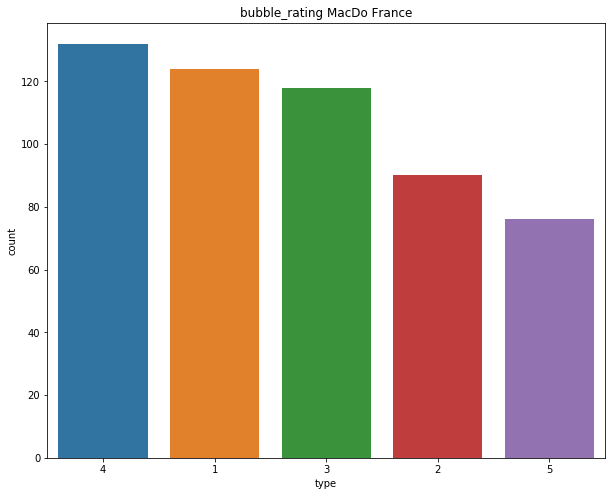

In [44]:
import seaborn as sns
sns.countplot(
  x='bubble_rating',
  data=data_clean1,
  order=data_clean1.bubble_rating.value_counts().index
)

plt.xlabel("type")
plt.title("bubble_rating MacDo France");

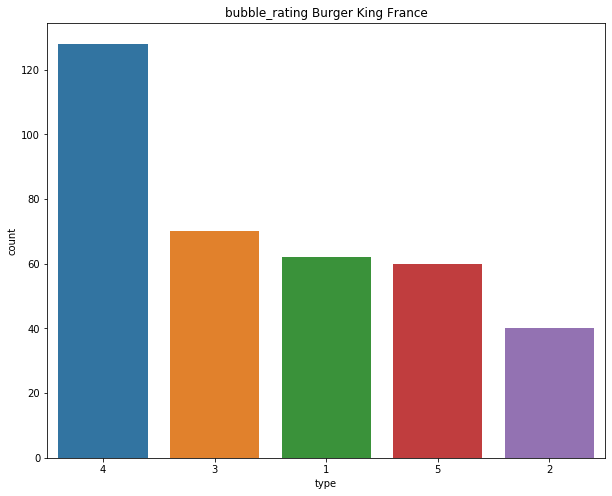

In [45]:
import seaborn as sns
sns.countplot(
  x='bubble_rating',
  data=data_clean_bk1,
  order=data_clean_bk1.bubble_rating.value_counts().index
)

plt.xlabel("type")
plt.title("bubble_rating Burger King France");

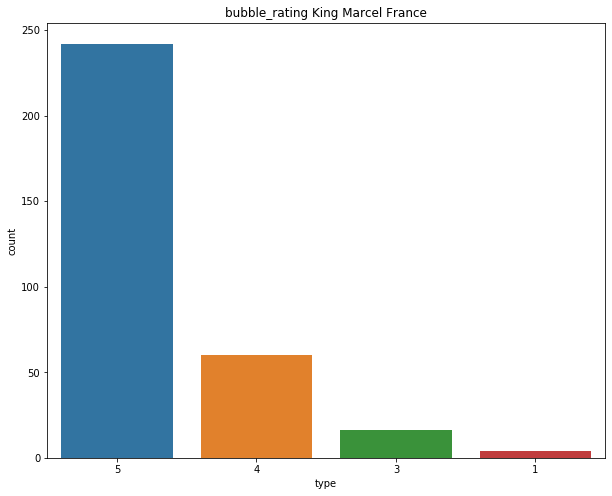

In [46]:
import seaborn as sns
sns.countplot(
  x='bubble_rating',
  data=data_clean_km1,
  order=data_clean_km1.bubble_rating.value_counts().index
)

plt.xlabel("type")
plt.title("bubble_rating King Marcel France");

### Interprétation 

* D'après ces 3 graphes on remarque que pour MacDo il y a un nombre important de clients ont donné un retour positif sur MacDo (4 étoiles) mais en meme temps il ya aussi un nombre important qui a donné un retour très négatif (1 étoile).
* Tandis que pour Burger King et meme si la moyenne et la médiane des notes des clients est proche de celles de Macdo mais on remarque qu'il ya une certaine cohérance au niveau des notes. le plus grand nombre de retour est (4 étoiles) ensuite on trouve les (3 étoiles).
* Pour King Marcel, on remarque une grande différence par rapport aux deux autres restaurants. La majorité des cients ont attribué une note de 5 ce qui prouve le résultat qu'on a obtenu précédemment de la moyenne et la médiane qui sont presque égale à 5.

### 3/ On va continuer maintenant avec le meme principe donc on va supposer que les clients qui ont donné une note >=3 ont aussi écrit un retour positif et les autres ont donné un retour négatif

In [47]:
data_clean_bk1["review_type"] = data_clean_bk1["bubble_rating"].apply(
  lambda x: "bad" if x < 3 else "good"
)

In [48]:
data_clean_km1["review_type"] = data_clean_km1["bubble_rating"].apply(
  lambda x: "bad" if x < 3 else "good"
)

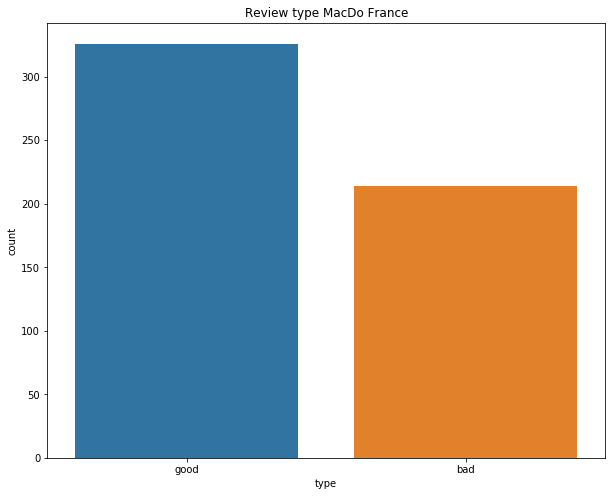

In [49]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=data_clean1,
  order=data_clean1.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type MacDo France");

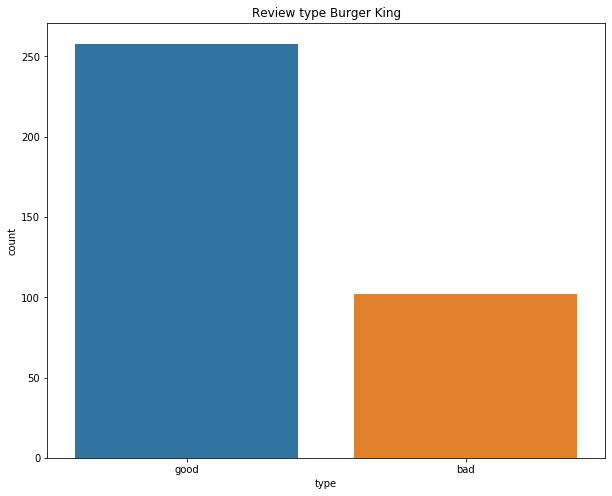

In [50]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=data_clean_bk1,
  order=data_clean_bk1.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type Burger King");

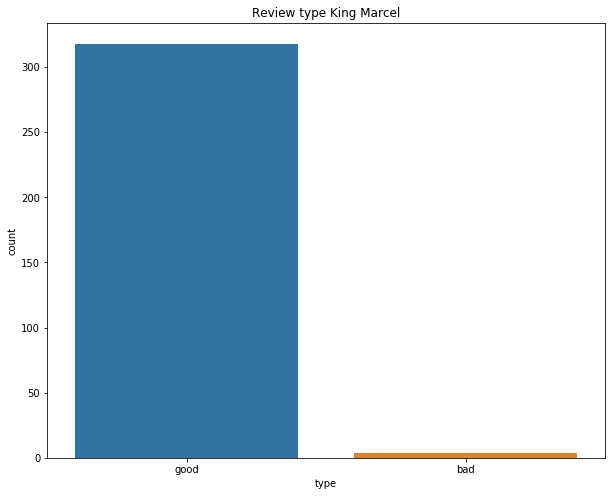

In [51]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=data_clean_km1,
  order=data_clean_km1.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type King Marcel");

### Interprétation

* Pour MacDo il ya tant de retours positifs que négatifs.  
* Pour Burger King la pourcentage des clients avec des retours positifs a augmenté.
* Tandis que pour King Marcel on remarque que presque 95% des retours sont positifs ( 3 étoiles ou plus).
* Donc ces 3 graphes confirment plus nos intreprétations précédentes. 

## 2 ème méthode: Evaluation de l'image de MacDo France en focalusiant sur les textes "des reviews"

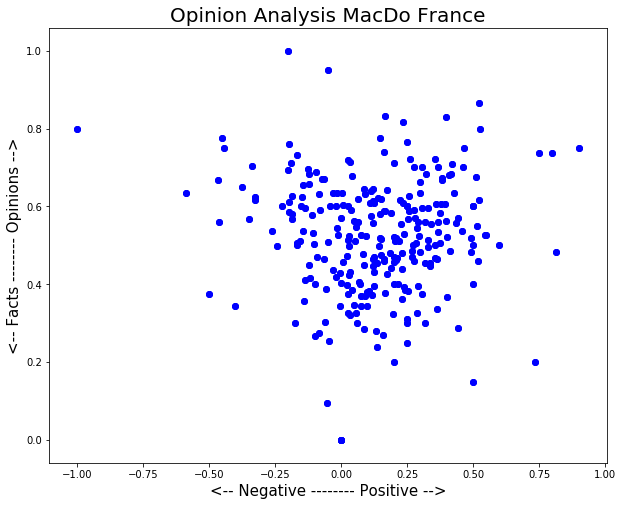

In [52]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean['polarity'] = data_clean['The review'].apply(pol)
data_clean['subjectivity'] = data_clean['The review'].apply(sub)
data_clean["Reviewer Name"]=df["reviewer_name"]

# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data_clean.index):
    x = data_clean.polarity.loc[index]
    y = data_clean.subjectivity.loc[index]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data_clean['Reviewer Name'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Opinion Analysis MacDo France', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

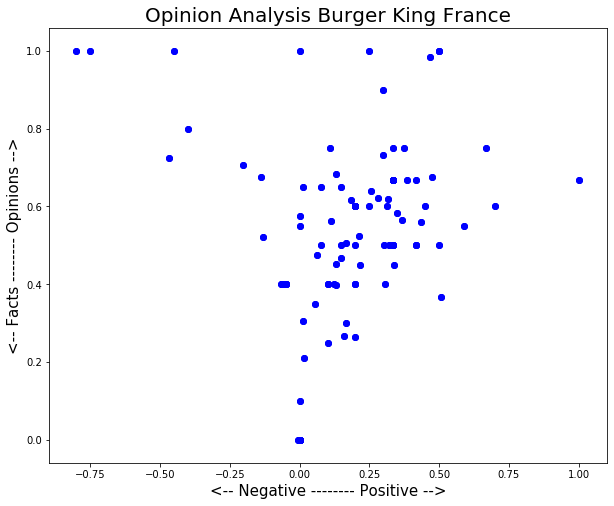

In [53]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean_bk['polarity'] = data_clean_bk['The review'].apply(pol)
data_clean_bk['subjectivity'] = data_clean_bk['The review'].apply(sub)
data_clean_bk["Reviewer Name"]=df_bk["reviewer_name"]

# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data_clean_bk.index):
    x = data_clean_bk.polarity.loc[index]
    y = data_clean_bk.subjectivity.loc[index]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data_clean['Reviewer Name'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Opinion Analysis Burger King France', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

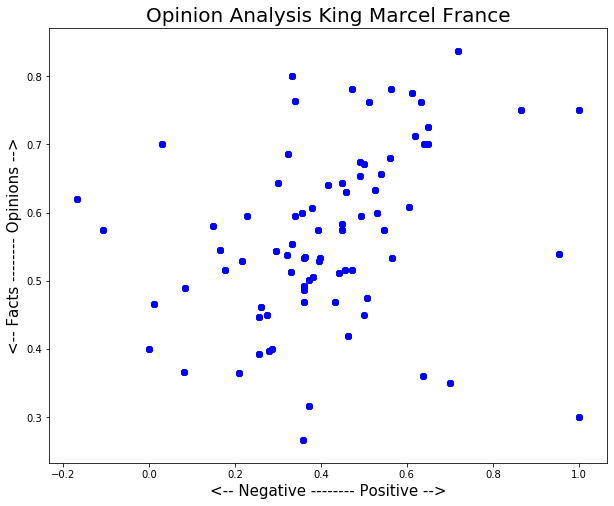

In [54]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean_km['polarity'] = data_clean_km['The review'].apply(pol)
data_clean_km['subjectivity'] = data_clean_km['The review'].apply(sub)
data_clean_km["Reviewer Name"]=df_km["reviewer_name"]

# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data_clean_km.index):
    x = data_clean_km.polarity.loc[index]
    y = data_clean_km.subjectivity.loc[index]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data_clean['Reviewer Name'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Opinion Analysis King Marcel France', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

### Interprétation

* D'après ces trois graphes on remarque que pour Burger King le nombre de clients dont la polarité est négative est très inférieurs de celui des clients de MacDo.
* Et pour King Marcel on peut voir que presque la totalité des clients ont écrit des textes dont la polarité est positive.
* Ces graphes confirment davantage les interprétations précédentes.

### Interprétation générale

D'après tous les analyses qu'on a effectué sur les retours et les notes donnés par les clients de trois restaurants concurrents (MacDonald's, Burger King et King Marcel France) on remarque que la réputation de MacDo est la plus mauvaise. 